# CartPole-v1 with REINFORCE

Algorithm 
* http://rll.berkeley.edu/deeprlcoursesp17/docs/lec2.pdf
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce

Gym documentation 
* https://gym.openai.com/docs/
* https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

In [4]:
import gym
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


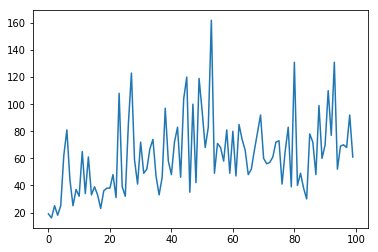

In [15]:
from policy import PolicyApprox, ReinforceLoss, PolicyGradient
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

dim_in = 4 #state [cart position, cart velocity, pole angle, pole velocity at tip]
dim_out = 2 #action space 0/1
hidden = 100
gamma = 1
policy_reinforce = PolicyApprox(dim_in,hidden,dim_out)
reinforce_loss = ReinforceLoss()
optimizer = optim.Adam(params=policy_reinforce.parameters(),lr=1e-2)
env = gym.make('CartPole-v1')

alg = PolicyGradient(policy_reinforce, reinforce_loss, optimizer, {"max_episodes":100,
                                                         "max_timesteps":200,
                                                         "batch_size":1})
losses, episode_length = alg.train(env=env,render=False)
plt.plot(episode_length)

In [16]:
#print(losses)

# CartPole-v1 with PPO

In [19]:
from policy import PolicyValueApprox, PPOLoss
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

dim_in = 4 #state [cart position, cart velocity, pole angle, pole velocity at tip]
dim_out = 3 #action space 0/1 + value function
hidden = 100
gamma = 0.99
eps = 0.2
lamb = 0.95
c1 = 1
c2 = 0.01

policy = PolicyValueApprox(dim_in, hidden, dim_out)
policy_old = copy.deepcopy(policy)
ppo_loss = PPOLoss(eps, gamma, lamb, c1, c2)
optimizer = optim.Adam(params=policy.parameters(),lr=1e-2)
env = gym.make('CartPole-v1')

MAX_E = 100
MAX_T = 200
batch_size = 1
render = True

rewards = []
probs = []
probs_old = []
values = []
loss = 0

episode_length = []
losses = []

for ep in range(MAX_E):
    rewards.clear()
    probs.clear()
    probs_old.clear()
    values.clear()
    observation = env.reset()
    
    for t in range(MAX_T):
        if render == True:
            env.render()
        probs_pol, value = policy(torch.tensor(data=observation,dtype=torch.float32))
        probs_pol_old, _ = policy_old(torch.tensor(data=observation,dtype=torch.float32))
        action = torch.multinomial(input=probs_pol, num_samples=1)[0].numpy()
        observation, reward, done, _ = env.step(action)
        # add to memory
        rewards.append(torch.unsqueeze(torch.tensor(reward),0))
        probs.append(torch.unsqueeze(probs_pol[[action]],0))
        probs_old.append(torch.unsqueeze(probs_pol_old[action],0))
        values.append(value)
        if done == True:
            break
    # calculate loss
    probs_tensor = torch.cat(probs)
    probs_old_tensor = torch.cat(probs_old)
    rewards_tensor = torch.cat(rewards)
    values_tensor = torch.cat(values)
    loss = loss + ppo_loss(probs=probs_tensor, probs_old=probs_old_tensor, rewards=rewards_tensor, values=values_tensor) / batch_size
    if ep % batch_size  == 0:
        # gradient ascent
        optimizer.zero_grad()
        policy_old = copy.deepcopy(policy)        
        loss.backward()
        optimizer.step()
        episode_length.append(t)
        losses.append(loss.detach().numpy())
        loss = 0
env.close()        

/home/vivi/anaconda3/envs/ml/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


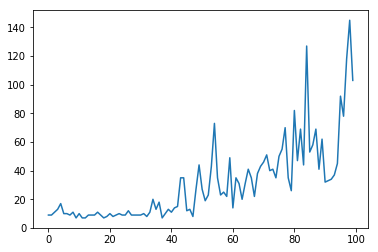

In [18]:
plt.plot(episode_rewards)